### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [ ]:
# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 12


# place resulting data and images into a folder with "paper" suffix
from _common import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [ ]:
import numpy as np
import time
import os

from _common.qiskit import execute

# Import HamLib helper functions (from _common)
from hamlib._common import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
from hamlib.qiskit import hamlib_simulation_kernel

# Import Observable helper functions
from hamlib._common import observables
from hamlib._common import evolution_exact

#########  Configure a QASM simulator, possibly noisy
backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model

# noisy, QV = 32 ...
#exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

#ideal ...
#exec_options.update({ "noise_model": None })

# set up the execution target
execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from hamlib._common.new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/B2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/NH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/CH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ]

# Select indices of the Hamiltonian(s) to test
# ham_indexes = range(len(hamiltonians))       # select all
#ham_indexes = [2,3]       # select subset, for example 2,3; for quick test, do just one of them

# get Hamiltonian name and params from list
# Note: we will loop over multiples here later
# hamiltonian_name, hamiltonian_params, _ = hamiltonians[7]     # just do a single Hamiltonian in this notebook


# print(f"\n*******************************************************************************************")

# print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")


### Load the Given Hamiltonian to get its Pauli terms and compute groups

In [4]:
grouping_results = {}
for i in range(len(hamiltonians)):
    
    hamiltonian_name, hamiltonian_params, _ = hamiltonians[i]     # just do a single Hamiltonian in this notebook
    grouping_results[hamiltonian_name] = []
    
    print(f"\n*******************************************************************************************")
    
    print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")
    # load the HamLib file for the given hamiltonian name
    hamlib_utils.load_hamlib_file(filename=hamiltonian_name)
    
    # return a sparse Pauli list of terms queried from the open HamLib file
    sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
    
    if not sparse_pauli_terms:
        print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
        sys.exit()
        
    print("")
    print(f"... dataset_name = {dataset_name}")
    print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
    #print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
    print("")

    group_method = "N"
    ks = [1, int(1/4 * num_qubits), int(1/2 * num_qubits), int(3/4 * num_qubits), num_qubits]
    for num_k in ks:
        print(f'----{num_k} group -----')
        
        pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
        
        print("")
        print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
        print(f"... Number of groups created: {len(pauli_term_groups)}")
        print("")
        grouping_results[hamiltonian_name].append(len(pauli_term_groups))

print('final grouping results for all hamiltonians')
for key, item in grouping_results.items():
    print(key)
    print(item)


*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 24

----1 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----3 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----6 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----9 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----12 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2


*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h

## Second trial

In [5]:
grouping_results = {}
for i in range(len(hamiltonians)):
    
    hamiltonian_name, hamiltonian_params, _ = hamiltonians[i]     # just do a single Hamiltonian in this notebook
    grouping_results[hamiltonian_name] = []
    
    print(f"\n*******************************************************************************************")
    
    print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")
    # load the HamLib file for the given hamiltonian name
    hamlib_utils.load_hamlib_file(filename=hamiltonian_name)
    
    # return a sparse Pauli list of terms queried from the open HamLib file
    sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)
    
    if not sparse_pauli_terms:
        print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
        sys.exit()
        
    print("")
    print(f"... dataset_name = {dataset_name}")
    print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
    #print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
    print("")

    group_method = "N"
    ks = [1, int(1/4 * num_qubits), int(1/2 * num_qubits), int(3/4 * num_qubits), num_qubits]
    for num_k in ks:
        print(f'----{num_k} group -----')
        
        pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
        
        print("")
        print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
        print(f"... Number of groups created: {len(pauli_term_groups)}")
        print("")
        grouping_results[hamiltonian_name].append(len(pauli_term_groups))

print('final grouping results for all hamiltonians')
for key, item in grouping_results.items():
    print(key)
    print(item)


*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 24

----1 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----3 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----6 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----9 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

----12 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2


*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h

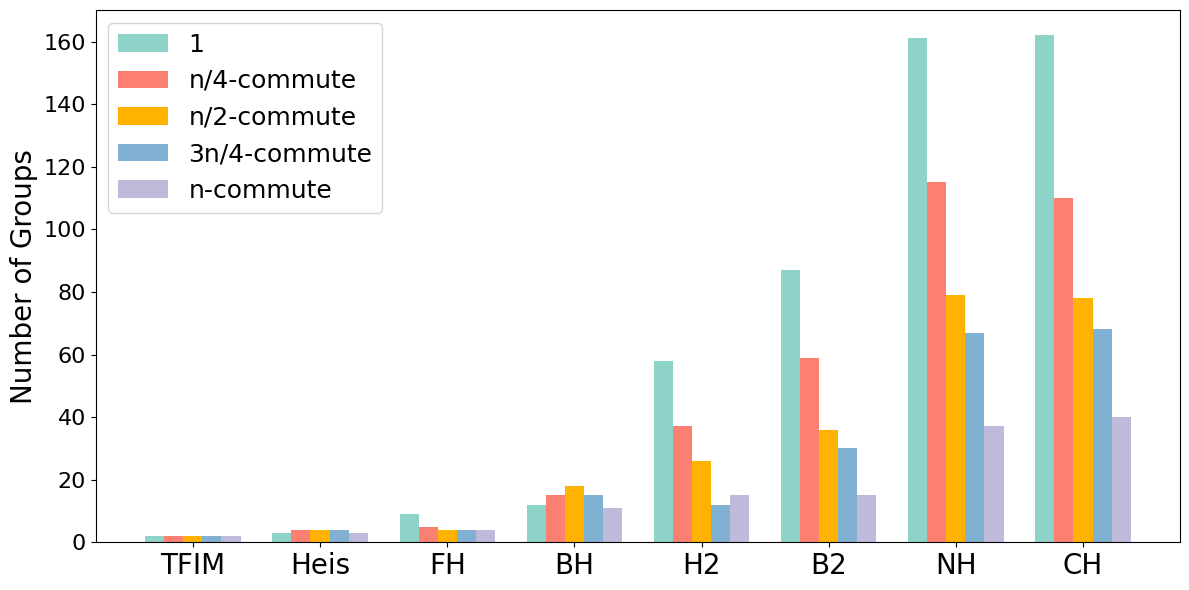

In [6]:
# Re-import libraries after reset
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['TFIM', 'Heis', 'FH', 'BH', 'H2', 'B2', 'NH', 'CH']
grouping_results = {
    '1': [2, 3, 9, 12, 58, 87, 161, 162],
    'n/4-commute': [2, 4, 5, 15, 37, 59, 115, 110],
    'n/2-commute': [2, 4, 4, 18, 26, 36, 79, 78],
    '3n/4-commute': [2, 4, 4, 15, 12, 30, 67, 68],
    'n-commute': [2, 3, 4, 11, 15, 15, 37, 40]
}

# Bar chart setup
x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))

# Colors (eye-friendly)
colors = ['#8dd3c7', '#fb8072', '#FFB300', '#80b1d3', '#bebada']


# Plot bars
for idx, (label, counts) in enumerate(grouping_results.items()):
    ax.bar(x + idx * width, counts, width, label=label, color=colors[idx])

# Formatting
# ax.set_xlabel('Models',)
ax.set_ylabel('Number of Groups', size=20)
# ax.set_title('Number of Groups for Different Commutativity Strategies')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(models,size =20)
ax.legend(fontsize=18)
ax.tick_params(axis='y', labelsize=16)
fig.tight_layout()
plt.savefig('exp1-k-group.pdf')
plt.show()


In [7]:
from matplotlib.backends.backend_pdf import PdfPages

# Prepare data (reusing your inputs)
models = ['TFIM', 'Heis', 'FH', 'BH', 'H2', 'B2', 'NH', 'CH']
grouping_results = {
    '1': [2, 3, 9, 12, 58, 87, 161, 162],
    'n/4-commute': [2, 4, 5, 15, 37, 59, 115, 110],
    'n/2-commute': [2, 4, 4, 18, 26, 36, 79, 78],
    '3n/4-commute': [2, 4, 4, 15, 12, 30, 67, 68],
    'n-commute': [2, 3, 4, 11, 15, 15, 37, 40]
}
errors = {
    '1': [0.168, 0.23700985430363491, 0.6277680602530227, 1.9147126497190854, 0.504, 0.12, 0.312, 0.2],
    'n/2-commute': [0.183, 0.3116526453554655, 0.5560090477568612, 2.049815460511045, 0.319, 0.08, 0.222, 0.14],
    'n-commute': [0.188, 0.2378343132024073, 0.5143599515312738, 1.8982632347808976, 0.252, 0.05, 0.151, 0.1]
}

# Colors
group_colors = ['#8dd3c7', '#fb8072', '#FFB300', '#80b1d3', '#bebada']

error_colors = ['#8dd3c7', '#bebada', '#80b1d3']

# Create PDF with two vertically stacked plots
with PdfPages('exp1-combined_plots.pdf') as pdf:
    fig, axs = plt.subplots(2, 1, figsize=(14, 12))

    # Top plot: grouping_results
    x = np.arange(len(models))
    width = 0.15
    for idx, (label, counts) in enumerate(grouping_results.items()):
        axs[0].bar(x + idx * width, counts, width, label=label, color=group_colors[idx])
    axs[0].set_ylabel('Number of Groups', size=26)
    axs[0].set_xticks(x + width * 2)
    axs[0].set_xticklabels(models, size=26)
    axs[0].legend(fontsize=26)
    axs[0].tick_params(axis='y', labelsize=24)

    # Bottom plot: errors
    width = 0.25
    for idx, (label, vals) in enumerate(errors.items()):
        axs[1].bar(x + idx * width - width, vals, width, label=label, color=error_colors[idx])
    axs[1].set_ylabel('Error', size=26)
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(models, size=26)
    axs[1].legend(fontsize=26)
    axs[1].tick_params(axis='y', labelsize=24)

    plt.tight_layout()
    pdf.savefig(fig)
    plt.close()

